In [1]:
import os
import zipfile
import subprocess
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

from Bio import SeqIO
from collections import Counter
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

## Explore train, test and subject info

In [2]:
train_df = pd.read_csv( "Train.csv")
test_df = pd.read_csv("Test.csv")
train_subjects_df = pd.read_csv("Train_Subjects.csv")
ss = pd.read_csv("SampleSubmission.csv")

Number of unique subjects in train_df: 66
Number of unique SampleType in train_df: 4
Number of unique Files in train_df: 2901
Unique values in SampleType: ['Stool' 'Nasal' 'Mouth' 'Skin']
Average number of files per SubjectID in train_df: 43.95


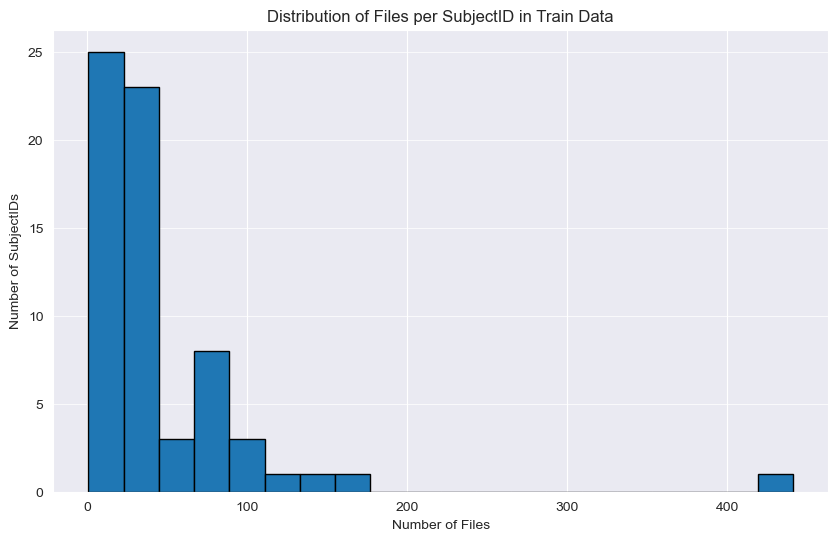

,filename,SampleType,SubjectID,SampleID
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ


In [3]:
print(f"Number of unique subjects in train_df: {train_df['SubjectID'].nunique()}")
print(f"Number of unique SampleType in train_df: {train_df['SampleType'].nunique()}")
print(f"Number of unique Files in train_df: {train_df['filename'].nunique()}")
print(f"Unique values in SampleType: {train_df['SampleType'].unique()}")
files_per_subject = train_df.groupby('SubjectID')['filename'].count().reset_index()
files_per_subject = files_per_subject.rename(columns={'filename': 'FileCount'})
average_files_per_subject = files_per_subject['FileCount'].mean()
print(f"Average number of files per SubjectID in train_df: {average_files_per_subject:.2f}")
plt.figure(figsize=(10, 6))
plt.hist(files_per_subject['FileCount'], bins=20, edgecolor='black')
plt.title('Distribution of Files per SubjectID in Train Data')
plt.xlabel('Number of Files')
plt.ylabel('Number of SubjectIDs')
plt.grid(axis='y', alpha=0.75)
plt.show()
train_df.head()

In [4]:
print(f"Number of unique Files in test_df: {test_df['filename'].nunique()}")
test_df.head()

Number of unique Files in test_df: 1068


,filename
0,ID_YBNOYC.mgb
1,ID_HPVLUO.mgb
2,ID_DQGGYD.mgb
3,ID_XZBUJB.mgb
4,ID_KRPYRQ.mgb


## Explore fastq files

In [ ]:
fastq_dir = "TrainFiles"
all_stats = []

for fname in os.listdir(fastq_dir):
    if not fname.endswith(".fastq"):
        continue

    path = os.path.join(fastq_dir, fname)
    read_lengths = []
    gc_counts = []
    nt_counts = Counter()

    try:
        for record in SeqIO.parse(path, "fastq"):
            seq = str(record.seq)
            read_lengths.append(len(seq))
            gc_counts.append(seq.count("G") + seq.count("C"))
            nt_counts.update(seq)

        if read_lengths:
            stats = {
                "file": fname,
                "num_reads": len(read_lengths),
                "avg_read_length": sum(read_lengths) / len(read_lengths),
                "avg_gc_content": sum(gc_counts) / sum(read_lengths),
                "A": nt_counts["A"],
                "T": nt_counts["T"],
                "G": nt_counts["G"],
                "C": nt_counts["C"]
            }
            all_stats.append(stats)

    except Exception as e:
        print(f"Error parsing {fname}: {e}")

df = pd.DataFrame(all_stats)
print(df.head())

In [ ]:
df.info()
plt.figure()
plt.hist(df["avg_gc_content"], bins=20, color='gray')
plt.title("GC Content Distribution")
plt.xlabel("GC Content")
plt.ylabel("Number of Files")
plt.show()

In [ ]:
fastq_dir = "TrainFiles"
labels = ['Nasal', 'Stool', 'Mouth', 'Skin']

file_list = [f for f in os.listdir(fastq_dir) if f.endswith(".fastq")]

data = {
    "filename": file_list,
    "label": [random.choice(labels) for _ in file_list]
}

df_labels = pd.DataFrame(data)

df_labels = df_labels.sort_values("filename").reset_index(drop=True)

df_labels.head()

In [ ]:
label_counts = df_labels['label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [ ]:
sns.heatmap(df.corr(), annot=True)

## Extract features

In [ ]:
def get_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]

def count_kmers(sequence, k):
    kmers = get_kmers(sequence, k)
    return Counter(kmers)

def normalize(counter):
    total = sum(counter.values())
    return {k: v / total for k, v in counter.items()}

def vectorize_kmers(kmer_counts, k):
    all_kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    return np.array([kmer_counts.get(kmer, 0) for kmer in all_kmers])

In [ ]:
class DNAEncoder(nn.Module):
    def __init__(self, seq_len=500, hidden_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        return self.encoder(x).squeeze(-1)